# Classification de Chiffres Manuscrits avec PyTorch
---
Objectif du projet
Il est demandé de concevoir, implémenter et évaluer un modèle de Deep Learning
destiné à la reconnaissance automatique de chiffres manuscrits (0 à 9) à l’aide de la
bibliothèque PyTorch.

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [210]:

plt.rcParams.update({
    # --- Фон ---
    "figure.facecolor": "#121212",
    "axes.facecolor": "#121212",
    "savefig.facecolor": "#121212",

    # --- Текст и оси ---
    "text.color": "white",
    "axes.labelcolor": "white",
    "axes.edgecolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",

    # --- Сетка ---
    "axes.grid": True,
    "grid.color": "#535252",
    "grid.alpha": 0.5,

    # --- Легенда ---
    "legend.facecolor": "#121212",
    "legend.edgecolor": "white",

    # --- Цвета линий (cycle) ---
    "axes.prop_cycle": plt.cycler(color=[
        "#6218B6",  # blue
        "#2532EE",  # orange
        "#1CE6C4",  # green
        "#0CD63F",  # red
        "#F1EE2A",  # purple
        "#F37C15",  # brown
        "#EE1924",  # cyan
    ]),

    # --- Толщина ---
    "lines.linewidth": 1.0,
})


In [211]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Préparation et Exploration des Données
---
- Importer le jeu de données MNIST en utilisant le module torchvision.datasets.
- Appliquer un prétraitement des données à l’aide de transforms.Compose, incluant :
     - la conversion des images en tenseurs,
     - la normalisation des valeurs de pixels.
- Réaliser une visualisation exploratoire en affichant une grille de six images
sélectionnées aléatoirement, accompagnées de leurs étiquettes respectives, afin
d’analyser la nature des données d’entrée.


In [212]:
# --- transformation ---
mean = (0.1307,)
std  = (0.3081,)


transform = transforms.Compose([
    # transforms.RandomCrop(128, padding=4),
    # transforms.RandomHorizontalFlip(0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# --- dataset ---
train_ds = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

In [213]:
print(len(train_ds), len(test_ds))

60000 10000


In [214]:
# --- dataloader ---
batch_size=128

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False)

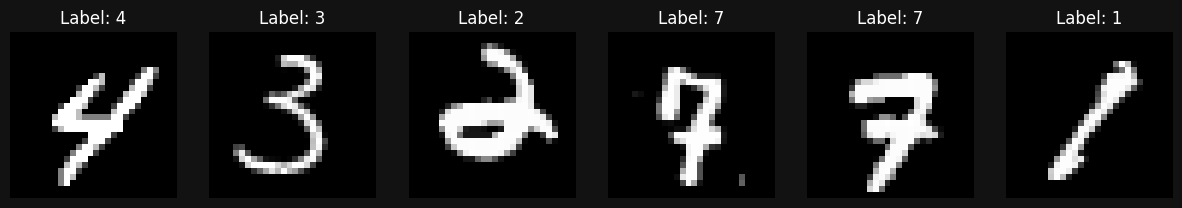

In [215]:
# --- visualisation ---

N = 6

fig, axes = plt.subplots(1, N, figsize=(15, 5))

for i in range(N):
    # chiosir l'image aléatoire
    idx = np.random.randint(len(test_ds))
    img, label = test_ds[idx]
        
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.show()

### Conception de l’Architecture du Modèle
---
Implémenter un modèle de réseau de neurones sous la forme d’une classe héritant de
nn.Module. en choisissant l’une des architectures suivantes ou procéder à une étude
comparative :
- Modèle 1: Modèle MLP (Multi-Layer Perceptron) :
aplatir les images d’entrée ;
implémenter au minimum deux couches entièrement connectées (nn.Linear).
- Modèle 2: Modèle CNN (Convolutional Neural Network) :
implémenter au minimum deux couches de convolution (nn.Conv2d) ;
intégrer des couches de sous-échantillonnage (nn.MaxPool2d).

In [216]:
class MLPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),           
            nn.ReLU(),
            nn.Linear(256, 10),
        )
    
    def forward(self, x):
        return self.net(x)

In [217]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3),   # 28-26
            nn.ReLU(),              # 26-26
            nn.MaxPool2d(2),      # 26-13

            nn.Conv2d(16, 32, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2)       
        )

        self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32 * 5 * 5, 10)  # logits
            )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

### Entraînement et Optimisation
---
1. Définir la fonction de perte CrossEntropyLoss.
2. Sélectionner un algorithme d’optimisation parmi Adam ou SGD.
3. Implémenter la boucle d’entraînement comprenant :
    - la propagation avant (forward pass) ;
    - le calcul de la perte ;
     -la rétro-propagation du gradient (backward pass) ;
    - la mise à jour des paramètres du modèle ;
    - la remise à zéro des gradients à chaque itération.
4. Visualiser l’évolution de la loss en fonction des époques à l’aide d’un graphique,
et analyser le comportement de la courbe (convergence, instabilité,
sur-apprentissage)

In [218]:
model_MLP = MLPModel().to(device)
model_CNN = CNNModel().to(device)



In [219]:
criterion = nn.CrossEntropyLoss() 

optimizer_MLP = optim.AdamW(model_MLP.parameters(), lr=1e-4)
optimizer_CNN = optim.AdamW(model_CNN.parameters(), lr=1e-4)

scheduler_MLP = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_MLP,
    mode="min",
    factor=0.5,
    patience=1
)

scheduler_CNN = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_CNN,
    mode="min",
    factor=0.5,
    patience=1
)


In [220]:
def train(model, criterion, optimizer, scheduler, num_epochs):

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):

        model.train()   # changer le mode de model

        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()   #  la remise à zéro des gradients à chaque itération
            outputs = model(inputs)   # la propagation avant (forward pass)
            loss = criterion(outputs, labels)   # le calcul de la perte 
            loss.backward()   # la rétro-propagation du gradient (backward pass)
            optimizer.step()   # la mise à jour des paramètres du modèle

            running_loss += loss.item() * inputs.size(0)   # calculer le loss total
            _, predicted = torch.max(outputs, 1)   # faire une predicte
            total += labels.size(0)   # quantite les prediction total
            correct += (predicted == labels).sum().item()   # quantite les prediction corect


        current_lr = optimizer.param_groups[0]['lr']    # learning rate courant
        
        train_losses.append(running_loss / total)   # souvegarger le loss
        train_accuracies.append(correct / total)   # souvegarger l'accurancy'
        
        # Evaluation sur le test set
        model.eval()   # changer le mode de model

        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        scheduler.step(running_loss)

        test_losses.append(running_loss / total)
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f} | "
            f"Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accuracies[-1]:.4f} | "
            f"Learning rate: {current_lr:.6f}")
    return train_losses, train_accuracies, test_losses, test_accuracies



In [221]:
num_epochs = 50

history_MLP = train(model_MLP, criterion, optimizer_MLP, scheduler_MLP, num_epochs)

Epoch 1/50 | Train Loss: 0.6167 | Train Acc: 0.8515 | Test Loss: 0.3115 | Test Acc: 0.9148 | Learning rate: 0.000100
Epoch 2/50 | Train Loss: 0.2852 | Train Acc: 0.9197 | Test Loss: 0.2462 | Test Acc: 0.9303 | Learning rate: 0.000100
Epoch 3/50 | Train Loss: 0.2324 | Train Acc: 0.9345 | Test Loss: 0.2090 | Test Acc: 0.9407 | Learning rate: 0.000100
Epoch 4/50 | Train Loss: 0.1976 | Train Acc: 0.9445 | Test Loss: 0.1839 | Test Acc: 0.9472 | Learning rate: 0.000100
Epoch 5/50 | Train Loss: 0.1714 | Train Acc: 0.9515 | Test Loss: 0.1613 | Test Acc: 0.9531 | Learning rate: 0.000100
Epoch 6/50 | Train Loss: 0.1507 | Train Acc: 0.9573 | Test Loss: 0.1454 | Test Acc: 0.9561 | Learning rate: 0.000100
Epoch 7/50 | Train Loss: 0.1337 | Train Acc: 0.9626 | Test Loss: 0.1318 | Test Acc: 0.9615 | Learning rate: 0.000100
Epoch 8/50 | Train Loss: 0.1197 | Train Acc: 0.9666 | Test Loss: 0.1218 | Test Acc: 0.9639 | Learning rate: 0.000100
Epoch 9/50 | Train Loss: 0.1081 | Train Acc: 0.9701 | Test Loss:

In [222]:


history_CNN = train(model_CNN, criterion, optimizer_CNN, scheduler_CNN, num_epochs)

Epoch 1/50 | Train Loss: 0.8703 | Train Acc: 0.7845 | Test Loss: 0.3018 | Test Acc: 0.9199 | Learning rate: 0.000100
Epoch 2/50 | Train Loss: 0.2484 | Train Acc: 0.9294 | Test Loss: 0.1854 | Test Acc: 0.9469 | Learning rate: 0.000100
Epoch 3/50 | Train Loss: 0.1753 | Train Acc: 0.9500 | Test Loss: 0.1375 | Test Acc: 0.9615 | Learning rate: 0.000100
Epoch 4/50 | Train Loss: 0.1396 | Train Acc: 0.9599 | Test Loss: 0.1158 | Test Acc: 0.9674 | Learning rate: 0.000100
Epoch 5/50 | Train Loss: 0.1178 | Train Acc: 0.9658 | Test Loss: 0.0968 | Test Acc: 0.9718 | Learning rate: 0.000100
Epoch 6/50 | Train Loss: 0.1034 | Train Acc: 0.9698 | Test Loss: 0.0881 | Test Acc: 0.9730 | Learning rate: 0.000100
Epoch 7/50 | Train Loss: 0.0927 | Train Acc: 0.9730 | Test Loss: 0.0787 | Test Acc: 0.9765 | Learning rate: 0.000100
Epoch 8/50 | Train Loss: 0.0846 | Train Acc: 0.9754 | Test Loss: 0.0724 | Test Acc: 0.9788 | Learning rate: 0.000100
Epoch 9/50 | Train Loss: 0.0780 | Train Acc: 0.9772 | Test Loss:

In [223]:
def show_result(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss par Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy par Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()



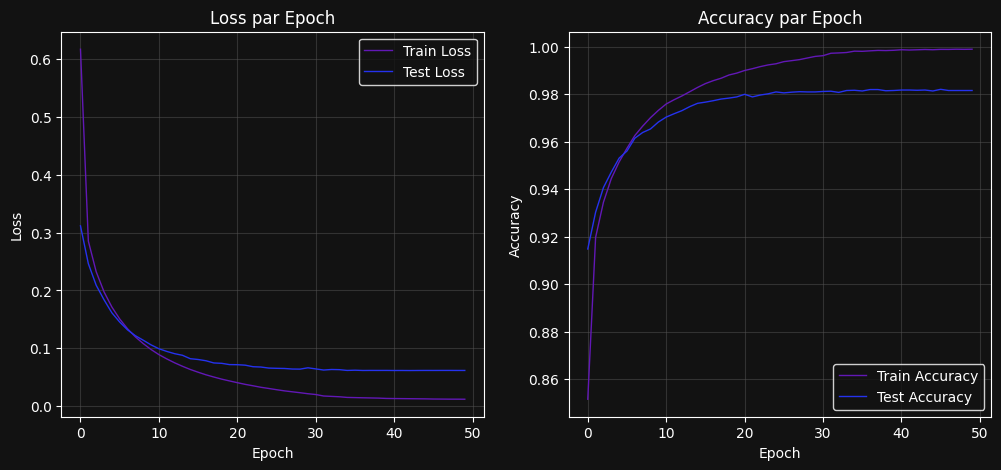

In [224]:
show_result(*history_MLP)

### Résumé
---
- Convergence : correcte et rapide
- Stabilité : bonne, pas d’oscillations
- Sur-apprentissage : faible, la généralisation est satisfaisante


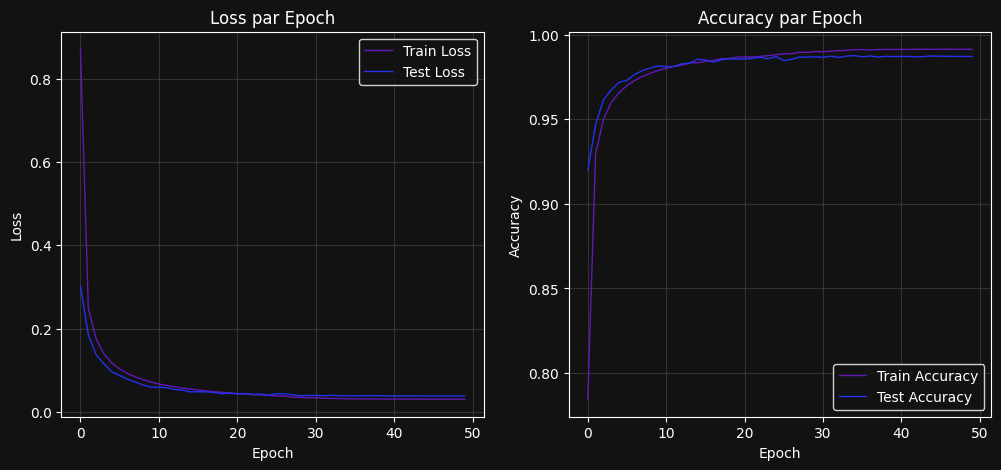

In [225]:
show_result(*history_CNN)

### Résumé:
---
- Convergence: le modèle converge rapidement et efficacement.

- Stabilité: les courbes sont lisses et monotones, sans fluctuations ni oscillations importantes, le modèle est stable durant tout l’entraînement.

- Sur-apprentissage (overfitting): la différence entre training et test accuracy est très faible (~0,3 %), et la loss de test ne croît pas. Le sur-apprentissage est minimal, la généralisation est très bonne.

- Apprentissage: la décroissance du learning rate à la fin (0,00005) aide à stabiliser la loss de test et à affiner les performances.

### Évaluation et Analyse des Résultats
---
1. Évaluer les performances du modèle sur le jeu de test en calculant la précision
globale (accuracy).
2. Afficher une matrice de confusion afin d’identifier les classes les plus
fréquemment confondues.
3. Sélectionner et afficher trois exemples d’images incorrectement classées, en
précisant pour chacune la prédiction du modèle ainsi que la vérité terrain

In [226]:
model_evol = model_CNN

In [ ]:
def pred_model(model):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

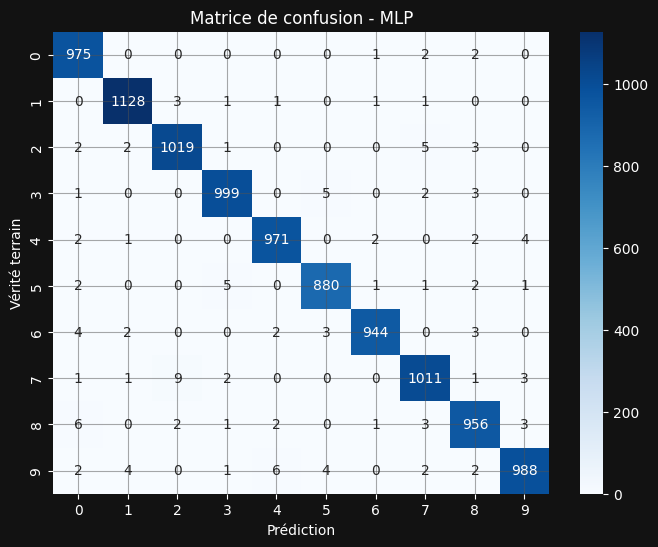

In [228]:
model_MLP.eval()

all_labels, all_preds = pred_model(model_evol)
# Matrice de confusion
cm_MLP = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm_MLP, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion - MLP")
plt.show()

### les classes les plus fréquemment confondues: 5 - 3, 7 - 2   --- pour MLP
---
### les classes les plus fréquemment confondues: 2 - 7, 6 - 0, 9 - 4   --- pour CNN

In [229]:
def get_misclassified(model, testloader, device, max_images=300):
    model.eval()
    imgs, true_labels, pred_labels = [], [], []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            mask = preds != labels
            if mask.any():
                imgs.extend(images[mask].cpu())
                true_labels.extend(labels[mask].cpu())
                pred_labels.extend(preds[mask].cpu())

            if len(imgs) >= max_images:
                break
    return imgs[:max_images], true_labels[:max_images], pred_labels[:max_images]




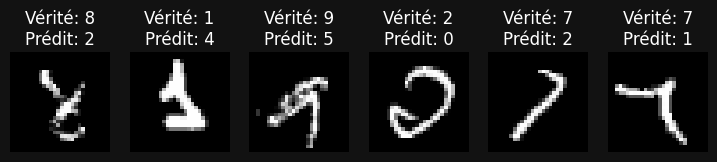

In [230]:
imgs, y_true, y_pred = get_misclassified(model_evol, testloader, device)

N = 6 
if len(y_pred) > N:

    plt.figure(figsize=(9,3))

    for i in range(N):
        idx = np.random.randint(len(y_pred))
        plt.subplot(1, N, i+1)
        plt.imshow(imgs[idx].squeeze(), cmap="gray")
        plt.title(f"Vérité: {y_true[idx]}\nPrédit: {y_pred[idx]}")
        plt.axis("off")

    plt.show()

### Ameloration de MLP MODEL

In [231]:
class MLPModelA(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),           
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )
    
    def forward(self, x):
        return self.net(x)

In [232]:
model_MLP_Amel = MLPModelA().to(device)

optimizer_MLP = optim.AdamW(model_MLP_Amel.parameters(), lr=1e-4)


scheduler_MLP = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_MLP,
    mode="min",
    factor=0.5,
    patience=1
)


In [233]:
history_MLP_1 = train(model_MLP_Amel, criterion, optimizer_MLP, scheduler_MLP, num_epochs)

Epoch 1/50 | Train Loss: 0.7756 | Train Acc: 0.7702 | Test Loss: 0.2955 | Test Acc: 0.9148 | Learning rate: 0.000100
Epoch 2/50 | Train Loss: 0.3367 | Train Acc: 0.9002 | Test Loss: 0.2120 | Test Acc: 0.9370 | Learning rate: 0.000100
Epoch 3/50 | Train Loss: 0.2620 | Train Acc: 0.9234 | Test Loss: 0.1723 | Test Acc: 0.9468 | Learning rate: 0.000100
Epoch 4/50 | Train Loss: 0.2178 | Train Acc: 0.9360 | Test Loss: 0.1437 | Test Acc: 0.9550 | Learning rate: 0.000100
Epoch 5/50 | Train Loss: 0.1873 | Train Acc: 0.9445 | Test Loss: 0.1253 | Test Acc: 0.9621 | Learning rate: 0.000100
Epoch 6/50 | Train Loss: 0.1661 | Train Acc: 0.9508 | Test Loss: 0.1139 | Test Acc: 0.9662 | Learning rate: 0.000100
Epoch 7/50 | Train Loss: 0.1481 | Train Acc: 0.9562 | Test Loss: 0.1037 | Test Acc: 0.9676 | Learning rate: 0.000100
Epoch 8/50 | Train Loss: 0.1345 | Train Acc: 0.9606 | Test Loss: 0.0937 | Test Acc: 0.9709 | Learning rate: 0.000100
Epoch 9/50 | Train Loss: 0.1226 | Train Acc: 0.9639 | Test Loss:

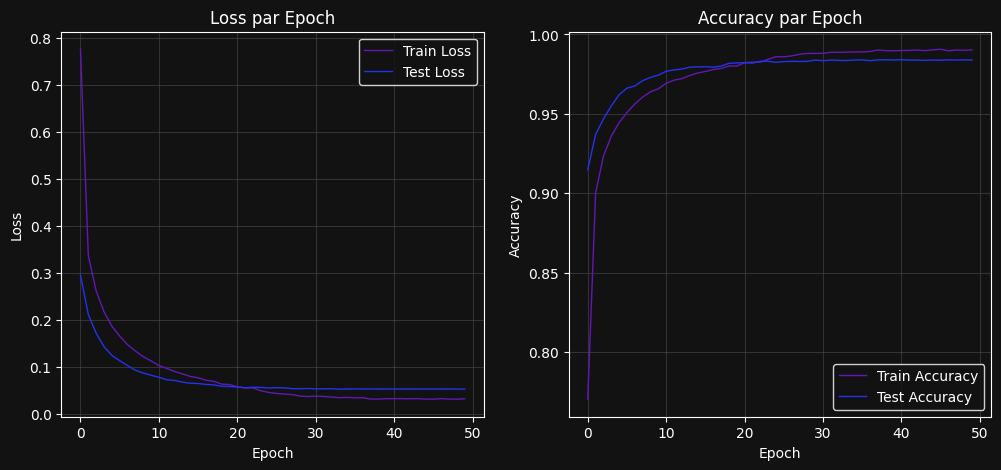

In [234]:
show_result(*history_MLP_1)

### Ameloration de CNN

In [235]:
class CNNModelA(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.Dropout2d(0.25),   
            nn.ReLU(),              
            nn.MaxPool2d(2),      

            nn.Conv2d(16, 32, 3, padding=1),
            nn.Dropout2d(0.25), 
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.Dropout2d(0.25),
            nn.ReLU(),
            nn.MaxPool2d(2)       
        )

        self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Dropout2d(0.4),
                nn.Linear(64 * 3 * 3, 10)  # logits
            )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [236]:
model_CNN_Amel = CNNModelA().to(device)

optimizer_CNN = optim.AdamW(model_CNN_Amel.parameters(), lr=1e-4)


scheduler_CNN = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_CNN,
    mode="min",
    factor=0.5,
    patience=1
)

history_CNN_1 = train(model_CNN_Amel, criterion, optimizer_CNN, scheduler_CNN, num_epochs)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/50 | Train Loss: 1.4775 | Train Acc: 0.5129 | Test Loss: 0.4041 | Test Acc: 0.9008 | Learning rate: 0.000100
Epoch 2/50 | Train Loss: 0.4919 | Train Acc: 0.8485 | Test Loss: 0.1997 | Test Acc: 0.9419 | Learning rate: 0.000100
Epoch 3/50 | Train Loss: 0.3324 | Train Acc: 0.9001 | Test Loss: 0.1512 | Test Acc: 0.9538 | Learning rate: 0.000100
Epoch 4/50 | Train Loss: 0.2726 | Train Acc: 0.9187 | Test Loss: 0.1234 | Test Acc: 0.9605 | Learning rate: 0.000100
Epoch 5/50 | Train Loss: 0.2333 | Train Acc: 0.9306 | Test Loss: 0.1064 | Test Acc: 0.9659 | Learning rate: 0.000100
Epoch 6/50 | Train Loss: 0.2076 | Train Acc: 0.9382 | Test Loss: 0.0962 | Test Acc: 0.9684 | Learning rate: 0.000100
Epoch 7/50 | Train Loss: 0.1931 | Train Acc: 0.9418 | Test Loss: 0.0882 | Test Acc: 0.9709 | Learning rate: 0.000100
Epoch 8/50 | Train Loss: 0.1787 | Train Acc: 0.9474 | Test Loss: 0.0787 | Test Acc: 0.9745 | Learning rate: 0.000100
Epoch 9/50 | Train Loss: 0.1622 | Train Acc: 0.9517 | Test Loss:

### Comparaison des modeles

In [237]:
def compar_hist(histories, names=None, figsize=(12,5)):

    epochs = range(1, len(histories[0][0]) + 1)  # train_losses = histories[i][0]

    # --- Loss ---
    plt.figure(figsize=figsize)
    for i, h in enumerate(histories):
        train_losses, train_acc, test_losses, test_acc = h
        label = f"{names[i]} Train" if names else f"Model {i+1} Train"
        plt.plot(epochs, train_losses, label=label, linestyle='--')
        label = f"{names[i]} Test" if names else f"Model {i+1} Test"
        plt.plot(epochs, test_losses, label=label, linestyle='-')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Test Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Accuracy ---
    plt.figure(figsize=figsize)
    for i, h in enumerate(histories):
        train_losses, train_acc, test_losses, test_acc = h
        label = f"{names[i]} Train" if names else f"Model {i+1} Train"
        plt.plot(epochs, train_acc, label=label, linestyle='--')
        label = f"{names[i]} Test" if names else f"Model {i+1} Test"
        plt.plot(epochs, test_acc, label=label, linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

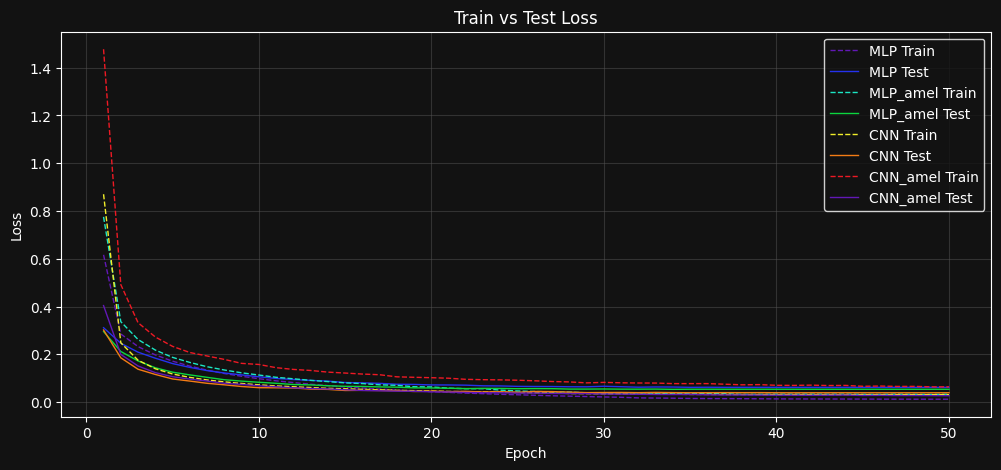

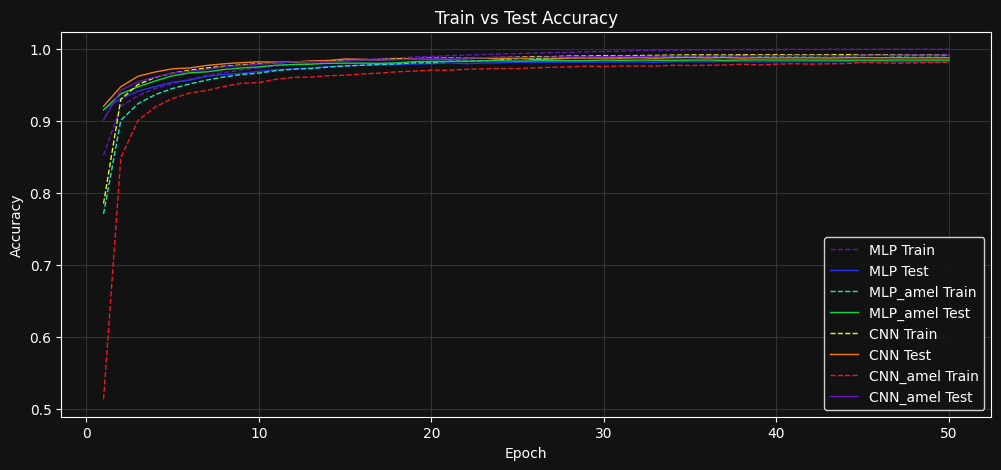

In [238]:
histories = [history_MLP, history_MLP_1, history_CNN, history_CNN_1]
names = ["MLP", "MLP_amel", "CNN", "CNN_amel"]

compar_hist(histories, names)

## Les resultats

In [239]:
from tabulate import tabulate

table = []

for h, n in zip(histories, names):
    table.append([n, str(max(h[3]))])

print(tabulate(table, headers=["Model name", "Meilleur test accurancy "], tablefmt="fancy_grid"))

╒══════════════╤════════════════════════════╕
│ Model name   │   Meilleur test accurancy  │
╞══════════════╪════════════════════════════╡
│ MLP          │                     0.9821 │
├──────────────┼────────────────────────────┤
│ MLP_amel     │                     0.9841 │
├──────────────┼────────────────────────────┤
│ CNN          │                     0.9876 │
├──────────────┼────────────────────────────┤
│ CNN_amel     │                     0.9912 │
╘══════════════╧════════════════════════════╛
